In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from keras.models import load_model, Sequential
from keras.layers import Dense, Activation
from keras_preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from keras.layers import Dense, Flatten
from keras.models import Model
import cv2
import cvlib as cv
from mtcnn import MTCNN
import glob
import pickle
import tensorflow as tf

In [29]:
def get_pred(model, x):
    cls= ["Face Covered", "Face not Covered"]
    img = cv2.resize(x,(224,224))
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.reshape(img, (1,224,224,3))
    pr  = model.predict(img)
    pr = np.array(pr)[0]
    idx = np.argmax(pr)
    conf = round(pr[idx]*100,2)
    return cls[idx] ,conf

def most_frequent(List): 
    counter = 0
    num = List[0] 
      
    for i in List: 
        curr_frequency = List.count(i) 
        if(curr_frequency> counter): 
            counter = curr_frequency 
            num = i 
  
    return num 

def get_embedding(model, face_pixels):
    import numpy as np
    face_pixels = cv2.resize(face_pixels,(160,160))
    #face_pixels = np.reshape(face_pixels,(1,160,160,3))
    from sklearn.preprocessing import Normalizer
    face_pixels = face_pixels.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    samples = np.expand_dims(face_pixels, axis=0)
    yhat = model.predict(samples)
    return yhat[0]


def Video(video_path = "C:/Users/DELL/Desktop/Santosh.mp4",mask_model_path = "C:/Users/DELL/Desktop/mask_detector.model",model_path = "C:/Users/DELL/Desktop/Kashmir Production/new_kashmir2.model", n = 10):
    try:
        import pandas as pd
        mask_model = tf.keras.models.load_model(mask_model_path)
        cls= ["Face Covered", "Face not Covered"]    
    
        nn_model = load_model(model_path)
        facenet_model = load_model("C:/Users/DELL/Desktop/Kashmir/facenet_keras.h5/model/facenet_keras.h5")
        face_detector = MTCNN()
        encoder_file = open("C:/Users/DELL/Desktop/encoder","rb")
        encoder = pickle.load(encoder_file)


        mask = []
        conf_mask = []
        person = []
        conf_person = []
        Frame = []
        temp = 0
        print("|", end ="")
        webcam = cv2.VideoCapture(video_path)
        while webcam.isOpened():
            status , frame = webcam.read()
            if (status == False):
                
                df = pd.DataFrame({"Face visuals":mask , "Face Confidence":conf_mask , "Recognition":person, "Recognition Confidence":conf_person})
                frame = []
                person = []
                accuracy = []
                for i in np.unique(df["Recognition"]):
                    person.append(i)
                    frame.append(Frame[np.where(max(df[df["Recognition"]==i]["Recognition Confidence"]))[0][0]])
                    accuracy.append(max(df[df["Recognition"]==i]["Recognition Confidence"]))
                
                return frame, person , accuracy
                cv2.destroyAllWindows() 
                webcam.release()
                break
            face, confidence = cv.detect_face(frame)
            for idx, f in enumerate(face):
                (startX, startY) = f[0], f[1]
                (endX, endY) = f[2], f[3]
                face = frame[startY:endY, startX:endX]
                label, confidence = get_pred(mask_model, face)
                mask.append(label)
                conf_mask.append(confidence)
                face = cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
                Frame.append(face)
            
                img = face
                img = get_embedding(facenet_model, img)
                img = np.array(img)
                img = np.reshape(img,(1,128))
                ###img = superr(img)
                # long distance scanning
                # save frame after super-resolution
                y_pred = nn_model.predict(img)
                y_pred = y_pred[0]
                confidence = max(y_pred)
                y_pred = np.argmax(y_pred)
                y_pred = encoder.inverse_transform([y_pred])[0]
                if(confidence*100 <= 50):
                    y_pred = "Unknown Person"
                    confidence = 1 - confidence
                person.append(y_pred)
                conf_person.append(round(confidence,2))
            
                if(temp%10 == 0):
                    print("=", end = "")
                temp += 1
            if cv2.waitKey(1) & 0xFF == ord('q'):
                webcam.release()
                df = pd.DataFrame({"Face visuals":mask , "Face Confidence":conf_mask , "Recognition":person, "Recognition Confidence":conf_person})
                frame = []
                person = []
                accuracy = []
                for i in np.unique(df["Recognition"]):
                    person.append(i)
                    frame.append(Frame[np.where(max(df[df["Recognition"]==i]["Recognition Confidence"]))[0][0]])
                    accuracy.append(max(df[df["Recognition"]==i]["Recognition Confidence"]))
                
                return frame, person , accuracy
                break
    except Exception as e:
        print("Code failed in Camera part")
        cv2.destroyAllWindows()
        webcam.release()
        print(e)

    # When everything is done, release the capture

In [31]:
a, b, c = Video()

C:\Users\DELL\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


|=

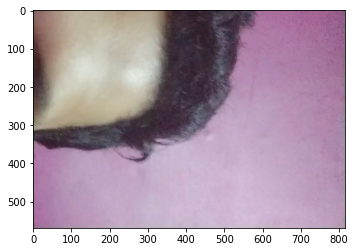

In [33]:
plt.imshow(a[0])

In [34]:
b

['Unknown Person']

In [35]:
c

[0.84]